<a href="https://colab.research.google.com/github/Amakudegloria/Berlin-Stores-Analysis/blob/main/Berlin_Stores_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
!pip install rtree
!pip install geopandas
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
#import geoplot.crs as gcrs
#import contextily as ctx
import shapely.wkt
from geopandas import sjoin
!pip install fiona
import os
!pip install descartes
!pip install rtree
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
os.chdir("/content/spatialindex-src-1.8.5")
!./configure
!make
!make install
!ldconfig
import fiona
import shapely.speedups
shapely.speedups.enable()
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

     |████████████████████████████████| 1.0MB 11.3MB/s 
     |████████████████████████████████| 1.0MB 11.0MB/s 
     |████████████████████████████████| 6.5MB 47.3MB/s 
     |████████████████████████████████| 14.8MB 261kB/s 
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  556k  100  556k    0     0   483k      0  0:00:01  0:00:01 --:--:--  483k
checking build system type... x86_64-unknown-linux-gnu
checking for g++... g++
checking whether the C++ compiler works... yes
checking for C++ compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether we are using the GNU C++ compiler... yes
checking whether g++ accepts -g... yes
checking how to run the C++ preprocessor... g++ -E
checking for a BSD-compatible install... /usr/bin/install -c
checking whether l

##**Data Loading**


In [ ]:
##loading the data from github files directly
sample_data = pd.read_csv("https://github.com/GloriaAmakudeC/Analytics-files/blob/master/all_sample_data.csv?raw=true",sep='\t')

# **Initial analysis**

## **Checking shape, dtypes, missing values, duplicates**

In [ ]:
##looking at the shape of the data
print(f"Sample data has {sample_data.shape[0]} rows and {sample_data.shape[1]} columns")

Sample data has 2262913 rows and 7 columns


In [ ]:
##looking at the head of labeled data
sample_data.head()

,Unnamed: 0,device_id,lat,lon,utc_timestamp,ts,date
0,0,42039,52.571806,13.311957,1610711155000,2021-01-15 12:45:55+01:00,2021-01-15
1,1,47261,52.506415,13.518467,1610737136000,2021-01-15 19:58:56+01:00,2021-01-15
2,2,32292,52.571226,13.517675,1610753301000,2021-01-16 00:28:21+01:00,2021-01-16
3,3,103416,52.649507,13.532222,1610733210000,2021-01-15 18:53:30+01:00,2021-01-15
4,4,109298,52.447100,13.631400,1610695780000,2021-01-15 08:29:40+01:00,2021-01-15


In [ ]:
##Drop an irrelevant column
sample_data = sample_data.drop("Unnamed: 0", 1)
sample_data

,device_id,lat,lon,utc_timestamp,ts,date
0,42039,52.571806,13.311957,1610711155000,2021-01-15 12:45:55+01:00,2021-01-15
1,47261,52.506415,13.518467,1610737136000,2021-01-15 19:58:56+01:00,2021-01-15
2,32292,52.571226,13.517675,1610753301000,2021-01-16 00:28:21+01:00,2021-01-16
3,103416,52.649507,13.532222,1610733210000,2021-01-15 18:53:30+01:00,2021-01-15
4,109298,52.447100,13.631400,1610695780000,2021-01-15 08:29:40+01:00,2021-01-15
...,...,...,...,...,...,...
2262908,38425,52.630631,13.299379,1610948426000,2021-01-18 06:40:26+01:00,2021-01-18
2262909,73565,52.426447,13.502953,1610984703000,2021-01-18 16:45:03+01:00,2021-01-18
2262910,36866,52.735919,13.378849,1610964602000,2021-01-18 11:10:02+01:00,2021-01-18
2262911,34774,52.514717,13.583217,1610951627000,2021-01-18 07:33:47+01:00,2021-01-18


In [ ]:
##looking at dtypes and column names of the data
print(sample_data.dtypes)

device_id          int64
lat              float64
lon              float64
utc_timestamp      int64
ts                object
date              object
dtype: object


In [ ]:
##looking at the continous varaiables of data
sample_data.describe()

,device_id,lat,lon,utc_timestamp
count,2.262913e+06,2.262913e+06,2.262913e+06,2.262913e+06
mean,3.807026e+04,5.250878e+01,1.341193e+01,1.610396e+12
std,3.197613e+04,7.287212e-02,1.122024e-01,5.125693e+08
min,1.000000e+00,5.227360e+01,1.315412e+01,1.609459e+12
25%,1.550400e+04,5.245556e+01,1.333030e+01,1.609961e+12
50%,3.172900e+04,5.251375e+01,1.341030e+01,1.610394e+12
75%,4.727000e+04,5.255336e+01,1.350071e+01,1.610829e+12
max,1.744100e+05,5.276195e+01,1.365212e+01,1.611274e+12


## **Some initial observation**
*  device_id is in integer format, should be converted to str
*  order_date is in string format should be converted to pandas date format
*  utc_timestamp is in string format should be converted to pandas date format



In [ ]:
##Checking for missing values in sample data
sample_data.isna().sum()

device_id        0
lat              0
lon              0
utc_timestamp    0
ts               0
date             0
dtype: int64



*   There are no missing values





In [ ]:
#Converting unix time to readable date in milliseconds (epoch)

sample_data['ts'] = (pd.to_datetime(sample_data['utc_timestamp'], unit='ms')
                     .dt.tz_localize('utc')
                     .dt.tz_convert('Europe/Berlin'))

#Create a separete date column
sample_data['date'] = pd.to_datetime(sample_data['ts']).dt.date

sample_data.head()

,device_id,lat,lon,utc_timestamp,ts,date
0,42039,52.571806,13.311957,1610711155000,2021-01-15 12:45:55+01:00,2021-01-15
1,47261,52.506415,13.518467,1610737136000,2021-01-15 19:58:56+01:00,2021-01-15
2,32292,52.571226,13.517675,1610753301000,2021-01-16 00:28:21+01:00,2021-01-16
3,103416,52.649507,13.532222,1610733210000,2021-01-15 18:53:30+01:00,2021-01-15
4,109298,52.447100,13.631400,1610695780000,2021-01-15 08:29:40+01:00,2021-01-15


In [ ]:
#Convert the DataFrame's Lat and Lon columns into appropriate Shapely geometries and then create a GeoDataFrame.
geometry = [Point(xy) for xy in zip(sample_data.lon, sample_data.lat)]

#Drop lat and lon because we dont need them for now.
sample_data = sample_data.drop(['lon', 'lat'], axis=1)
sample_data = GeoDataFrame(sample_data, crs="EPSG:4326", geometry=geometry)
sample_data

,device_id,utc_timestamp,ts,date,geometry
0,42039,1610711155000,2021-01-15 12:45:55+01:00,2021-01-15,POINT (13.31196 52.57181)
1,47261,1610737136000,2021-01-15 19:58:56+01:00,2021-01-15,POINT (13.51847 52.50642)
2,32292,1610753301000,2021-01-16 00:28:21+01:00,2021-01-16,POINT (13.51768 52.57123)
3,103416,1610733210000,2021-01-15 18:53:30+01:00,2021-01-15,POINT (13.53222 52.64951)
4,109298,1610695780000,2021-01-15 08:29:40+01:00,2021-01-15,POINT (13.63140 52.44710)
...,...,...,...,...,...
2262908,38425,1610948426000,2021-01-18 06:40:26+01:00,2021-01-18,POINT (13.29938 52.63063)
2262909,73565,1610984703000,2021-01-18 16:45:03+01:00,2021-01-18,POINT (13.50295 52.42645)
2262910,36866,1610964602000,2021-01-18 11:10:02+01:00,2021-01-18,POINT (13.37885 52.73592)
2262911,34774,1610951627000,2021-01-18 07:33:47+01:00,2021-01-18,POINT (13.58322 52.51472)


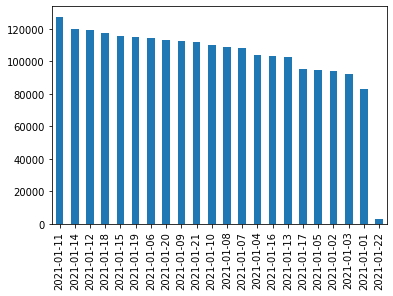

In [ ]:
sample_data.dtypes

sample_data['date'].value_counts().plot.bar()

In [ ]:
#loading the stores datasets files directly from github

store_data= pd.read_csv('https://github.com/Amakudegloria/Data_Analysis_Exercise/raw/main/stores.csv')
store_data

,store_id,store_name,wkt
0,place_1,McDonald's,POLYGON ((13.4611920000000005 52.4709870000000...
1,place_2,McDonald's,POLYGON ((13.4683480000000007 52.5471599999999...
2,place_3,McDonald's,POLYGON ((13.3128810000000009 52.4197929999999...
3,place_4,McDonald's,POLYGON ((13.3635780000000004 52.5606039999999...
4,place_5,McDonald's,POLYGON ((13.3230909999999998 52.5613460000000...
...,...,...,...
242,place_243,Renault,POLYGON ((13.3686120000000006 52.4831089999999...
243,place_244,Renault,POLYGON ((13.2863860000000003 52.5164690000000...
244,place_245,Lexus,POLYGON ((13.5198269999999994 52.5265330000000...
245,place_246,Sparkasse,POLYGON ((13.5389199999999992 52.6766369999999...


In [ ]:
##looking at the shape of the store_data
print(f"The Store data has {store_data.shape[0]} rows and {store_data.shape[1]} columns")

The Store data has 247 rows and 3 columns


In [ ]:
##looking at dtypes and column names of the store_data
print(store_data.dtypes)

store_id      object
store_name    object
wkt           object
dtype: object


In [ ]:
##Checking for missing values in data
print(store_data.isna().sum())

store_id      0
store_name    0
wkt           0
dtype: int64


* There are no missing values

In [ ]:
##looking at the continous varaiables of the store data
store_data.describe()

,store_id,store_name,wkt
count,247,247,247
unique,247,10,247
top,place_146,Aldi,POLYGON ((13.4318469999999994 52.3580609999999...
freq,1,84,1


In [ ]:
#Calculating the number of store and unique store ids
num_sName = store_data["store_name"].nunique()
num_sID = store_data["store_id"].nunique()

print(f"The Store data set has {num_sName} stores and {num_sID} unique store ids")

The Store data set has 10 stores and 247 unique store ids


In [ ]:
store_data['store_name'].value_counts()

Aldi           84
Rewe           75
McDonald's     34
Burger King    16
Kaufland       15
Renault         9
Mercedes        8
Subway          3
Sparkasse       2
Lexus           1
Name: store_name, dtype: int64

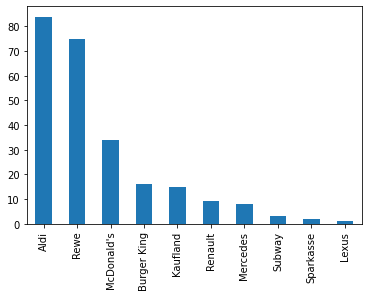

In [ ]:
store_data['store_name'].value_counts().plot.bar()


* Aldi and Rewe has the most number of stores with 84 and 75 stores respectively

In [ ]:
#The format for the store data polygon is WKT, so we need to convert it to a shapely Polygon
geometry = store_data['wkt'].map(shapely.wkt.loads)

#drop wkt column as it is no longer required
store_data = store_data.drop('wkt', axis=1)

#convert the data to a Geodataframe
store_data = gpd.GeoDataFrame(store_data, crs="EPSG:4326", geometry=geometry)
store_data

,store_id,store_name,geometry
0,place_1,McDonald's,"POLYGON ((13.46119 52.47099, 13.46103 52.47066..."
1,place_2,McDonald's,"POLYGON ((13.46835 52.54716, 13.46841 52.54716..."
2,place_3,McDonald's,"POLYGON ((13.31288 52.41979, 13.31303 52.41966..."
3,place_4,McDonald's,"POLYGON ((13.36358 52.56060, 13.36358 52.56061..."
4,place_5,McDonald's,"POLYGON ((13.32309 52.56135, 13.32307 52.56128..."
...,...,...,...
242,place_243,Renault,"POLYGON ((13.36861 52.48311, 13.36833 52.48317..."
243,place_244,Renault,"POLYGON ((13.28639 52.51647, 13.28640 52.51637..."
244,place_245,Lexus,"POLYGON ((13.51983 52.52653, 13.52021 52.52654..."
245,place_246,Sparkasse,"POLYGON ((13.53892 52.67664, 13.53866 52.67654..."


In [ ]:
#To check if the point is within the polygon and join both data to a new dataframe called "User Data"

user_data = gpd.sjoin(sample_data, store_data, how="inner", op='within')
user_data

,device_id,utc_timestamp,ts,date,geometry,index_right,store_id,store_name
976,61490,1610690078000,2021-01-15 06:54:38+01:00,2021-01-15,POINT (13.33911 52.58865),159,place_160,Rewe
37206,42048,1610729876000,2021-01-15 17:57:56+01:00,2021-01-15,POINT (13.33898 52.58873),159,place_160,Rewe
119716,56315,1611228437000,2021-01-21 12:27:17+01:00,2021-01-21,POINT (13.33906 52.58870),159,place_160,Rewe
156928,47521,1610714708000,2021-01-15 13:45:08+01:00,2021-01-15,POINT (13.33857 52.58879),159,place_160,Rewe
228879,34348,1610815823000,2021-01-16 17:50:23+01:00,2021-01-16,POINT (13.33900 52.58868),159,place_160,Rewe
...,...,...,...,...,...,...,...,...
1738415,24012,1609946411000,2021-01-06 16:20:11+01:00,2021-01-06,POINT (13.49573 52.43088),133,place_134,Aldi
1860243,51184,1610723294000,2021-01-15 16:08:14+01:00,2021-01-15,POINT (13.62192 52.44626),71,place_72,Aldi
1968044,78629,1610733037000,2021-01-15 18:50:37+01:00,2021-01-15,POINT (13.62190 52.44598),71,place_72,Aldi
2030862,16083,1609948975000,2021-01-06 17:02:55+01:00,2021-01-06,POINT (13.28661 52.59192),65,place_66,Aldi


# **A total number of unique visitors (i.e. device ids).**

In [ ]:
#Total count of a device ids

user_data['device_id'].count()

2747

# **Resolving the user visits per store, i.e. filter the GPS signals through polygons.**

In [ ]:
#Grouping the data accordingly by store and place to have an overview of all the stores's performances

user_data.groupby(['store_name', 'store_id']).device_id.count().sort_values(ascending=False)


store_name  store_id 
Kaufland    place_214    159
            place_215     97
            place_224     84
            place_227     84
Rewe        place_210     76
                        ... 
Aldi        place_73       1
            place_95       1
            place_65       1
            place_118      1
Subway      place_53       1
Name: device_id, Length: 186, dtype: int64

# **Group the resolved visits by date (yyyy-mm-dd), store_name, and store_id.**

In [ ]:
#Group the resoled visits by date (yyyy-mm-dd), store_name, and store_id and count the number of unique visits

grouped_rv = user_data.groupby(['date', 'store_name','store_id']).device_id.count()

grouped_rv

date        store_name   store_id 
2021-01-01  Aldi         place_64     1
            Burger King  place_42     4
                         place_43     1
                         place_50     1
            McDonald's   place_17     1
                                     ..
2021-01-21  Rewe         place_199    1
                         place_200    1
                         place_203    2
                         place_209    3
                         place_210    4
Name: device_id, Length: 1202, dtype: int64



##  **A total number of GPS signals per place_id/date.**

In [ ]:
#To find the total GPS signals per place_id/date, we need to group the data by date and store_id and count all signals

total_signals = user_data.groupby(['date','store_id']).geometry.count().sort_values(ascending=False)
total_signals

date        store_id 
2021-01-16  place_214    23
2021-01-09  place_214    20
2021-01-16  place_216    15
            place_215    15
2021-01-18  place_214    13
                         ..
2021-01-09  place_192     1
2021-01-16  place_178     1
2021-01-09  place_187     1
            place_182     1
2021-01-01  place_141     1
Name: geometry, Length: 1202, dtype: int64

In [ ]:
#Checking days with the highest unique visits 

visit_per_day = user_data.groupby(['date']).device_id.count().sort_values(ascending=False)

visit_per_day

date
2021-01-16    218
2021-01-15    201
2021-01-09    195
2021-01-08    173
2021-01-21    170
2021-01-04    167
2021-01-14    158
2021-01-02    157
2021-01-18    145
2021-01-19    143
2021-01-05    140
2021-01-06    138
2021-01-11    138
2021-01-07    135
2021-01-12    129
2021-01-20    128
2021-01-13    117
2021-01-17     29
2021-01-10     26
2021-01-01     26
2021-01-03     14
Name: device_id, dtype: int64

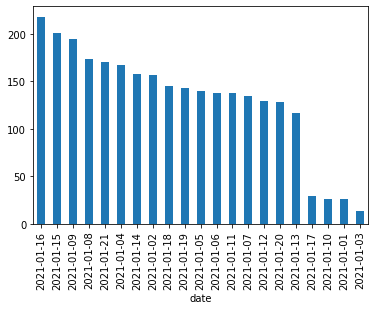

In [ ]:
visit_per_day.plot.bar()

In [ ]:
#Total unique visitors per date, store name, and store id

total_uniq_vis = user_data.groupby(['date', 'store_name','store_id']).device_id.count().sort_values(ascending=False)
total_uniq_vis

date        store_name  store_id 
2021-01-16  Kaufland    place_214    23
2021-01-09  Kaufland    place_214    20
2021-01-16  Kaufland    place_215    15
                        place_216    15
2021-01-08  Kaufland    place_227    13
                                     ..
2021-01-09  Kaufland    place_225     1
                        place_224     1
2021-01-16  McDonald's  place_18      1
                        place_2       1
2021-01-01  Aldi        place_64      1
Name: device_id, Length: 1202, dtype: int64

In [ ]:
#Total count of visitors for each store

visits_per_store =user_data.groupby(['store_name']).device_id.count().sort_values(ascending=False)
visits_per_store

store_name
Rewe           1027
Kaufland        933
Aldi            475
McDonald's      190
Burger King      49
Lexus            28
Renault          24
Mercedes         19
Subway            2
Name: device_id, dtype: int64

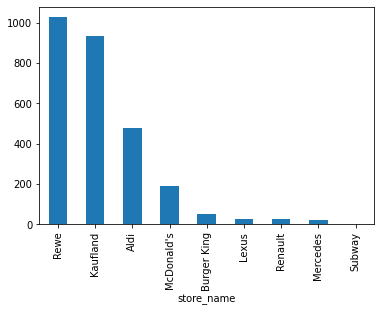

In [ ]:
visits_per_store.plot.bar()

# **A total number of unique visitors belonging to each affinity group.**

In [ ]:
#Read the Apple affinity dataset and find the counts of each device id 

apple_affi = pd.read_csv('https://github.com/Amakudegloria/Data_Analysis_Exercise/blob/main/affinity/addidas_affi.csv?raw=true')
apple_affi#= apple_affi[['device_id']].value_counts()


#convert the series to a dataframe and rename the coulmn
#apple_affi = apple_affi.to_frame().rename(columns={0: 'apple'}).reset_index()
#apple_affi

,device_id
0,50844
1,90618
2,97745
3,45843
4,164807
...,...
6771,112211
6772,112457
6773,77740
6774,50930


In [ ]:
#Read the addidas affinity dataset and find the counts of each device id 

addidas_affi = pd.read_csv('https://github.com/Amakudegloria/Data_Analysis_Exercise/blob/main/affinity/addidas_affi.csv?raw=true')

addidas_affi= addidas_affi[['device_id']].value_counts()


#convert the series to a dataframe and rename the coulmn
addidas_affi = addidas_affi.to_frame().rename(columns={0: 'addidas'}).reset_index()
addidas_affi

,device_id,addidas
0,174383,1
1,57047,1
2,56559,1
3,56602,1
4,56625,1
...,...,...
6771,114605,1
6772,114624,1
6773,114642,1
6774,114664,1


In [ ]:
#Read the employed affinity dataset and find the counts of each device id 

employed_affi = pd.read_csv('https://github.com/Amakudegloria/Data_Analysis_Exercise/blob/main/affinity/employed_affi.csv?raw=true')

employed_affi= employed_affi[['device_id']].value_counts()


#convert the series to a dataframe and rename the coulmn
employed_affi = employed_affi.to_frame().rename(columns={0: 'employed'}).reset_index()
employed_affi

,device_id,employed
0,174387,1
1,58013,1
2,57762,1
3,57805,1
4,57815,1
...,...,...
8571,117001,1
8572,117029,1
8573,117036,1
8574,117038,1


In [ ]:
#Read the bmw_affi affinity dataset and find the counts of each device id 

bmw_affi = pd.read_csv('https://github.com/Amakudegloria/Data_Analysis_Exercise/blob/main/affinity/bmw_affi.csv?raw=true')

bmw_affi= bmw_affi[['device_id']].value_counts()


#convert the series to a dataframe and rename the coulmn
bmw_affi = bmw_affi.to_frame().rename(columns={0: 'bmw'}).reset_index()
bmw_affi

,device_id,bmw
0,174377,1
1,58131,1
2,58066,1
3,58064,1
4,58037,1
...,...,...
9720,115846,1
9721,115829,1
9722,115763,1
9723,115736,1


In [36]:
#Read the female affinity dataset and find the counts of each device id 

female_affi = pd.read_csv('https://github.com/Amakudegloria/Data_Analysis_Exercise/raw/main/affinity/female_affi.csv?raw=true')

female_affi= female_affi[['device_id']].value_counts()


#convert the series to a dataframe and rename the coulmn
female_affi = female_affi.to_frame().rename(columns={0: 'female'}).reset_index()
female_affi

,device_id,female
0,174414,1
1,114806,1
2,114798,1
3,114799,1
4,114800,1
...,...,...
89410,144611,1
89411,144612,1
89412,144613,1
89413,144614,1


In [37]:
#Read the h_&_m affinity dataset and find the counts of each device id 

h_m_affi = pd.read_csv('https://github.com/Amakudegloria/Data_Analysis_Exercise/blob/main/affinity/h___m_affi.csv?raw=true')

h_m_affi= h_m_affi[['device_id']].value_counts()


#convert the series to a dataframe and rename the coulmn
h_m_affi = h_m_affi.to_frame().rename(columns={0: 'h_m'}).reset_index()
h_m_affi

,device_id,h_m
0,174408,1
1,57141,1
2,57783,1
3,57820,1
4,57841,1
...,...,...
7213,115131,1
7214,115137,1
7215,115169,1
7216,115182,1


In [38]:
#Read the high_income affinity dataset and find the counts of each device id 

high_income_affi = pd.read_csv('https://github.com/Amakudegloria/Data_Analysis_Exercise/blob/main/affinity/high_income_affi.csv?raw=true')

high_income_affi = high_income_affi[['device_id']].value_counts()


#convert the series to a dataframe and rename the coulmn
high_income_affi = high_income_affi.to_frame().rename(columns={0: 'high_income'}).reset_index()
high_income_affi

,device_id,high_income
0,99999,1
1,33349,1
2,33314,1
3,33319,1
4,33324,1
...,...,...
19995,66669,1
19996,66674,1
19997,66679,1
19998,66684,1


In [39]:
#Read the honda affinity dataset and find the counts of each device id 

honda_affi = pd.read_csv('https://github.com/Amakudegloria/Data_Analysis_Exercise/blob/main/affinity/honda_affi.csv?raw=true')

honda_affi = honda_affi[['device_id']].value_counts()


#convert the series to a dataframe and rename the coulmn
honda_affi = honda_affi.to_frame().rename(columns={0: 'honda'}).reset_index()
honda_affi

,device_id,honda
0,174413,1
1,58731,1
2,58366,1
3,58353,1
4,58334,1
...,...,...
14413,117048,1
14414,117006,1
14415,117001,1
14416,116981,1


In [40]:
#Read the job_seeking affinity dataset and find the counts of each device id 

job_seeking_affi = pd.read_csv('https://github.com/Amakudegloria/Data_Analysis_Exercise/blob/main/affinity/job_seeking_affi.csv?raw=true')

job_seeking_affi = job_seeking_affi[['device_id']].value_counts()


#convert the series to a dataframe and rename the coulmn
job_seeking_affi = job_seeking_affi.to_frame().rename(columns={0: 'job_seeking'}).reset_index()
job_seeking_affi

,device_id,job_seeking
0,174414,1
1,57789,1
2,57878,1
3,57827,1
4,57824,1
...,...,...
9898,116561,1
9899,116560,1
9900,116539,1
9901,116471,1


In [41]:
#Read the low income affinity dataset and find the counts of each device id 

low_income_affi = pd.read_csv('https://github.com/Amakudegloria/Data_Analysis_Exercise/blob/main/affinity/low_income_affi.csv?raw=true')

low_income_affi = low_income_affi[['device_id']].value_counts()


#convert the series to a dataframe and rename the coulmn
low_income_affi = low_income_affi.to_frame().rename(columns={0: 'low_income'}).reset_index()
low_income_affi

,device_id,low_income
0,174410,1
1,58120,1
2,58150,1
3,58145,1
4,58140,1
...,...,...
34878,116305,1
34879,116310,1
34880,116315,1
34881,116320,1


In [42]:
#Read the male affinity dataset and find the counts of each device id 

male_affi = pd.read_csv('https://github.com/Amakudegloria/Data_Analysis_Exercise/blob/main/affinity/male_affi.csv?raw=true')

male_affi = male_affi[['device_id']].value_counts()


#convert the series to a dataframe and rename the coulmn
male_affi = male_affi.to_frame().rename(columns={0: 'male'}).reset_index()
male_affi

,device_id,male
0,84999,1
1,28326,1
2,28328,1
3,28329,1
4,28330,1
...,...,...
84995,56667,1
84996,56668,1
84997,56669,1
84998,56670,1


In [43]:
#Read the mercedes_benz affinity dataset and find the counts of each device id 

mercedes_benz_affi = pd.read_csv('https://github.com/Amakudegloria/Data_Analysis_Exercise/blob/main/affinity/mercedes_benz_affi.csv?raw=true')

mercedes_benz_affi = mercedes_benz_affi[['device_id']].value_counts()


#convert the series to a dataframe and rename the coulmn
mercedes_benz_affi = mercedes_benz_affi.to_frame().rename(columns={0: 'mercedes_benz'}).reset_index()
mercedes_benz_affi

,device_id,mercedes_benz
0,174409,1
1,58194,1
2,58450,1
3,58432,1
4,58418,1
...,...,...
10369,116078,1
10370,116069,1
10371,116025,1
10372,116010,1


In [44]:
#Read the middle_income affinity dataset and find the counts of each device id 

middle_income_affi= pd.read_csv('https://github.com/Amakudegloria/Data_Analysis_Exercise/blob/main/affinity/middle_income_affi.csv?raw=true')

middle_income_affi = middle_income_affi[['device_id']].value_counts()


#convert the series to a dataframe and rename the coulmn
middle_income_affi = middle_income_affi.to_frame().rename(columns={0: 'middle_income'}).reset_index()
middle_income_affi

,device_id,middle_income
0,174413,1
1,58143,1
2,58127,1
3,58128,1
4,58131,1
...,...,...
104644,116278,1
104645,116281,1
104646,116282,1
104647,116283,1


In [45]:
#Read the retired affinity dataset and find the counts of each device id 

retired_affi= pd.read_csv('https://github.com/Amakudegloria/Data_Analysis_Exercise/blob/main/affinity/retired_affi.csv?raw=true')

retired_affi = retired_affi[['device_id']].value_counts()


#convert the series to a dataframe and rename the coulmn
retired_affi = retired_affi.to_frame().rename(columns={0: 'retired'}).reset_index()
retired_affi

,device_id,retired
0,174388,1
1,57806,1
2,57871,1
3,57873,1
4,57883,1
...,...,...
5778,116756,1
5779,116762,1
5780,116773,1
5781,116800,1


In [46]:
#Read the student dataset and find the counts of each device id 

student_affi= pd.read_csv('https://github.com/Amakudegloria/Data_Analysis_Exercise/blob/main/affinity/student_affi.csv?raw=true')

student_affi = student_affi[['device_id']].value_counts()


#convert the series to a dataframe and rename the coulmn
student_affi = student_affi.to_frame().rename(columns={0: 'student'}).reset_index()
student_affi

,device_id,student
0,174414,1
1,57955,1
2,58071,1
3,58064,1
4,58063,1
...,...,...
12856,116852,1
12857,116834,1
12858,116829,1
12859,116824,1


In [47]:
#Read the tommy hilfiger dataset and find the counts of each device id 

tommy_hilfiger_affi= pd.read_csv('https://github.com/Amakudegloria/Data_Analysis_Exercise/blob/main/affinity/tommy_hilfiger_affi.csv?raw=true')

tommy_hilfiger_affi = tommy_hilfiger_affi[['device_id']].value_counts()


#convert the series to a dataframe and rename the coulmn
tommy_hilfiger_affi = tommy_hilfiger_affi.to_frame().rename(columns={0: 'tommy_hilfiger'}).reset_index()
tommy_hilfiger_affi

,device_id,tommy_hilfiger
0,174413,1
1,58044,1
2,57872,1
3,57879,1
4,57881,1
...,...,...
6066,115431,1
6067,115438,1
6068,115476,1
6069,115483,1


In [48]:
#Create a list of all the datasets to be merged

all_affin_data = [user_data, apple_affi, addidas_affi, employed_affi, bmw_affi, 
                            female_affi, h_m_affi, high_income_affi, honda_affi,
                            job_seeking_affi, low_income_affi, male_affi, mercedes_benz_affi,
                            middle_income_affi, retired_affi, student_affi,tommy_hilfiger_affi]

In [49]:
#Now lets merge all datasets

from functools import reduce

All_df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['device_id'], how='left'
                                           ),all_affin_data).fillna(0)

All_df_merged

,device_id,utc_timestamp,ts,date,geometry,index_right,store_id,store_name,addidas,employed,bmw,female,h_m,high_income,honda,job_seeking,low_income,male,mercedes_benz,middle_income,retired,student,tommy_hilfiger
0,61490,1610690078000,2021-01-15 06:54:38+01:00,2021-01-15,POINT (13.33911 52.58865),159,place_160,Rewe,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,42048,1610729876000,2021-01-15 17:57:56+01:00,2021-01-15,POINT (13.33898 52.58873),159,place_160,Rewe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,56315,1611228437000,2021-01-21 12:27:17+01:00,2021-01-21,POINT (13.33906 52.58870),159,place_160,Rewe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,47521,1610714708000,2021-01-15 13:45:08+01:00,2021-01-15,POINT (13.33857 52.58879),159,place_160,Rewe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,34348,1610815823000,2021-01-16 17:50:23+01:00,2021-01-16,POINT (13.33900 52.58868),159,place_160,Rewe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2742,24012,1609946411000,2021-01-06 16:20:11+01:00,2021-01-06,POINT (13.49573 52.43088),133,place_134,Aldi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2743,51184,1610723294000,2021-01-15 16:08:14+01:00,2021-01-15,POINT (13.62192 52.44626),71,place_72,Aldi,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2744,78629,1610733037000,2021-01-15 18:50:37+01:00,2021-01-15,POINT (13.62190 52.44598),71,place_72,Aldi,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2745,16083,1609948975000,2021-01-06 17:02:55+01:00,2021-01-06,POINT (13.28661 52.59192),65,place_66,Aldi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [50]:
#To get a total unique visitors belonging to each affinity group, we find the sum of a all affinities per device id 

total_affi_group = All_df_merged.drop(['utc_timestamp', 'index_right', 
                'store_id', 'store_name', 'device_id'], axis=1).sum().astype(int)


#convert the series to a pandas dataframe and rename the column
total_affi_group = total_affi_group.to_frame().rename(columns={0: 'Total_affin_group'}).reset_index()
total_affi_group

,index,Total_affin_group
0,addidas,133
1,employed,140
2,bmw,226
3,female,154
4,h_m,97
5,high_income,448
6,honda,305
7,job_seeking,135
8,low_income,603
9,male,2593
